In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from LSTM_model import get_LSTM_Classifier
from dataloader import LSSTSourceDataSet, ts_length
from loss import WHXE_Loss
from taxonomy import get_taxonomy_tree, get_prediction_probs, get_highest_prob_path

from argparse import ArgumentParser
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow import keras

2024-04-26 13:31:20.966222: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-26 13:31:21.715966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9373] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 13:31:21.717557: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 13:31:21.888585: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1534] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-26 13:31:22.221725: I tensorflow/core/platform/cpu_feature_guar

## Load and balance the tensors:

In [2]:
def load(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

X_ts = load("processed/x_ts.pkl")
X_static = load("processed/x_static.pkl")
Y = load("processed/y.pkl")
lengths = load("processed/lengths.pkl")
astrophysical_classes = load("processed/a_labels.pkl")
elasticc_classes = load("processed/e_label.pkl")

In [3]:
# Balance the data set in some way
max_class_count = 10000

X_ts_balanced = []
X_static_balanced = []
Y_balanced = []
lengths_balanced = []
astrophysical_classes_balanced = []
elasticc_classes_balanced = []

for c in np.unique(astrophysical_classes):
    
    print(c)
    idx = np.where(np.array(astrophysical_classes) == c)[0]
    
    if len(idx) > max_class_count:
        idx = idx[:max_class_count]
 
    X_ts_balanced += [X_ts[i] for i in idx]
    X_static_balanced += [X_static[i][2] for i in idx]
    Y_balanced += [Y[i] for i in idx]
    astrophysical_classes_balanced += [astrophysical_classes[i] for i in idx]
    elasticc_classes_balanced += [elasticc_classes[i] for i in idx]

print(np.unique(astrophysical_classes_balanced, return_counts=True))
all_classes = list(set(astrophysical_classes))
all_classes.sort()

def get_labels(astrophysical_class):
    
    l = np.zeros(19) 
    l[all_classes.index(astrophysical_class)] = 1
    return l
    
print(all_classes)

AGN
CART
Cepheid
Delta Scuti
Dwarf Novae
EB
ILOT
KN
M-dwarf Flare
PISN
RR Lyrae
SLSN
SNI91bg
SNII
SNIa
SNIax
SNIb/c
TDE
uLens
(array(['AGN', 'CART', 'Cepheid', 'Delta Scuti', 'Dwarf Novae', 'EB',
       'ILOT', 'KN', 'M-dwarf Flare', 'PISN', 'RR Lyrae', 'SLSN',
       'SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c', 'TDE', 'uLens'],
      dtype='<U13'), array([10000,  3517,  5901,  8849,  3439, 10000,  3197,  1896,   796,
       10000,  6014, 10000, 10000, 10000, 10000, 10000, 10000, 10000,
        7537]))
['AGN', 'CART', 'Cepheid', 'Delta Scuti', 'Dwarf Novae', 'EB', 'ILOT', 'KN', 'M-dwarf Flare', 'PISN', 'RR Lyrae', 'SLSN', 'SNI91bg', 'SNII', 'SNIa', 'SNIax', 'SNIb/c', 'TDE', 'uLens']


In [4]:
# Pad for TF masking layer
for ind in range(len(X_ts_balanced)):
    print(f"{(ind/len(X_ts_balanced) * 100):.3f} %", end="\r")
    X_ts_balanced[ind] = np.pad(X_ts_balanced[ind], ((0, ts_length - len(X_ts_balanced[ind])), (0, 0)))

In [5]:
# Split into train and validation
X_ts_train, X_ts_val, X_static_train, X_static_val, Y_train, Y_val, astrophysical_classes_train, astrophysical_classes_val, elasticc_classes_train, elasticc_classes_val = train_test_split(X_ts_balanced, X_static_balanced, Y_balanced, astrophysical_classes_balanced, elasticc_classes_balanced, shuffle=True, random_state = 40, test_size = 0.1)

# Do some processing for tensorflow
X_ts_train = np.squeeze(np.array(X_ts_train))
X_ts_val = np.squeeze(np.array(X_ts_val))

X_static_train = np.squeeze(np.array(X_static_train))
X_static_val = np.squeeze(np.array(X_static_val))

Y_train = np.squeeze(np.array(Y_train))
Y_val = np.squeeze(np.array(Y_val))

## Attempting non hierarchichal, multi label classification.

In [6]:
# Loss and optimizer
tree = get_taxonomy_tree()
loss_object = WHXE_Loss(tree, astrophysical_classes_train) 
criterion = loss_object.compute_loss

In [7]:
# Inputs for model
ts_dim = 5
static_dim = 1
output_dim = 26
latent_size = 64

num_epochs = 100
batch_size = 1024

In [8]:
model = get_LSTM_Classifier(ts_dim, static_dim, output_dim, latent_size, criterion)

2024-04-26 13:33:24.247395: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31127 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:3a:00.0, compute capability: 7.0
2024-04-26 13:33:24.248858: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1926] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 31127 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:89:00.0, compute capability: 7.0


In [9]:

early_stopping = EarlyStopping(
                          patience=5,
                          min_delta=0.001,                               
                          monitor="val_loss",
                          restore_best_weights=True
                          )


history = model.fit(x = [X_ts_train, X_static_train],  y = Y_train, validation_data=([X_ts_val, X_static_val], Y_val), epochs=num_epochs, batch_size = batch_size, callbacks=[early_stopping])


model.save(f"models/RedshiftLatent_{latent_size}.keras")

Epoch 1/100


2024-04-26 13:33:33.767988: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_35/output/_22'
2024-04-26 13:33:34.349837: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90000
2024-04-26 13:33:35.181289: I external/local_xla/xla/service/service.cc:168] XLA service 0x14bfa8b31060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-26 13:33

125/125 [==============================] - 20s 98ms/step - loss: 0.2848 - accuracy: 7.8721e-06 - val_loss: 0.2563 - val_accuracy: 0.0000e+00
Epoch 2/100
125/125 [==============================] - 10s 81ms/step - loss: 0.2340 - accuracy: 0.0000e+00 - val_loss: 0.2242 - val_accuracy: 0.0000e+00
Epoch 3/100
125/125 [==============================] - 10s 81ms/step - loss: 0.2079 - accuracy: 0.0000e+00 - val_loss: 0.2024 - val_accuracy: 0.0000e+00
Epoch 4/100
125/125 [==============================] - 10s 81ms/step - loss: 0.1861 - accuracy: 7.8721e-06 - val_loss: 0.1750 - val_accuracy: 0.0000e+00
Epoch 5/100
125/125 [==============================] - 10s 81ms/step - loss: 0.1693 - accuracy: 0.0000e+00 - val_loss: 0.1639 - val_accuracy: 0.0000e+00
Epoch 6/100
125/125 [==============================] - 10s 81ms/step - loss: 0.1590 - accuracy: 0.0000e+00 - val_loss: 0.1837 - val_accuracy: 0.0000e+00
Epoch 7/100
125/125 [==============================] - 10s 81ms/step - loss: 0.1547 - accuracy

## Load the saved model

In [10]:
model1 = keras.models.load_model(f"models/RedshiftLatent_{latent_size}.keras", compile=False)

In [16]:
Y_val_pred = model1.predict([X_ts_val, X_static_val])

for i in range(Y_val_pred.shape[0]):
    
    pseudo_probs, weighted_tree = get_prediction_probs(Y_val_pred[[i], :])
    leaf_prob , _ = get_highest_prob_path(weighted_tree)
    Y_val_pred[i, -19:] =  leaf_prob
    
Y_val_pred = np.argmax(Y_val_pred[:, -19:], axis=1)
Y_val_true = np.argmax(Y_val[:, -19:], axis=1)

442/442 [==============================] - 4s 9ms/step


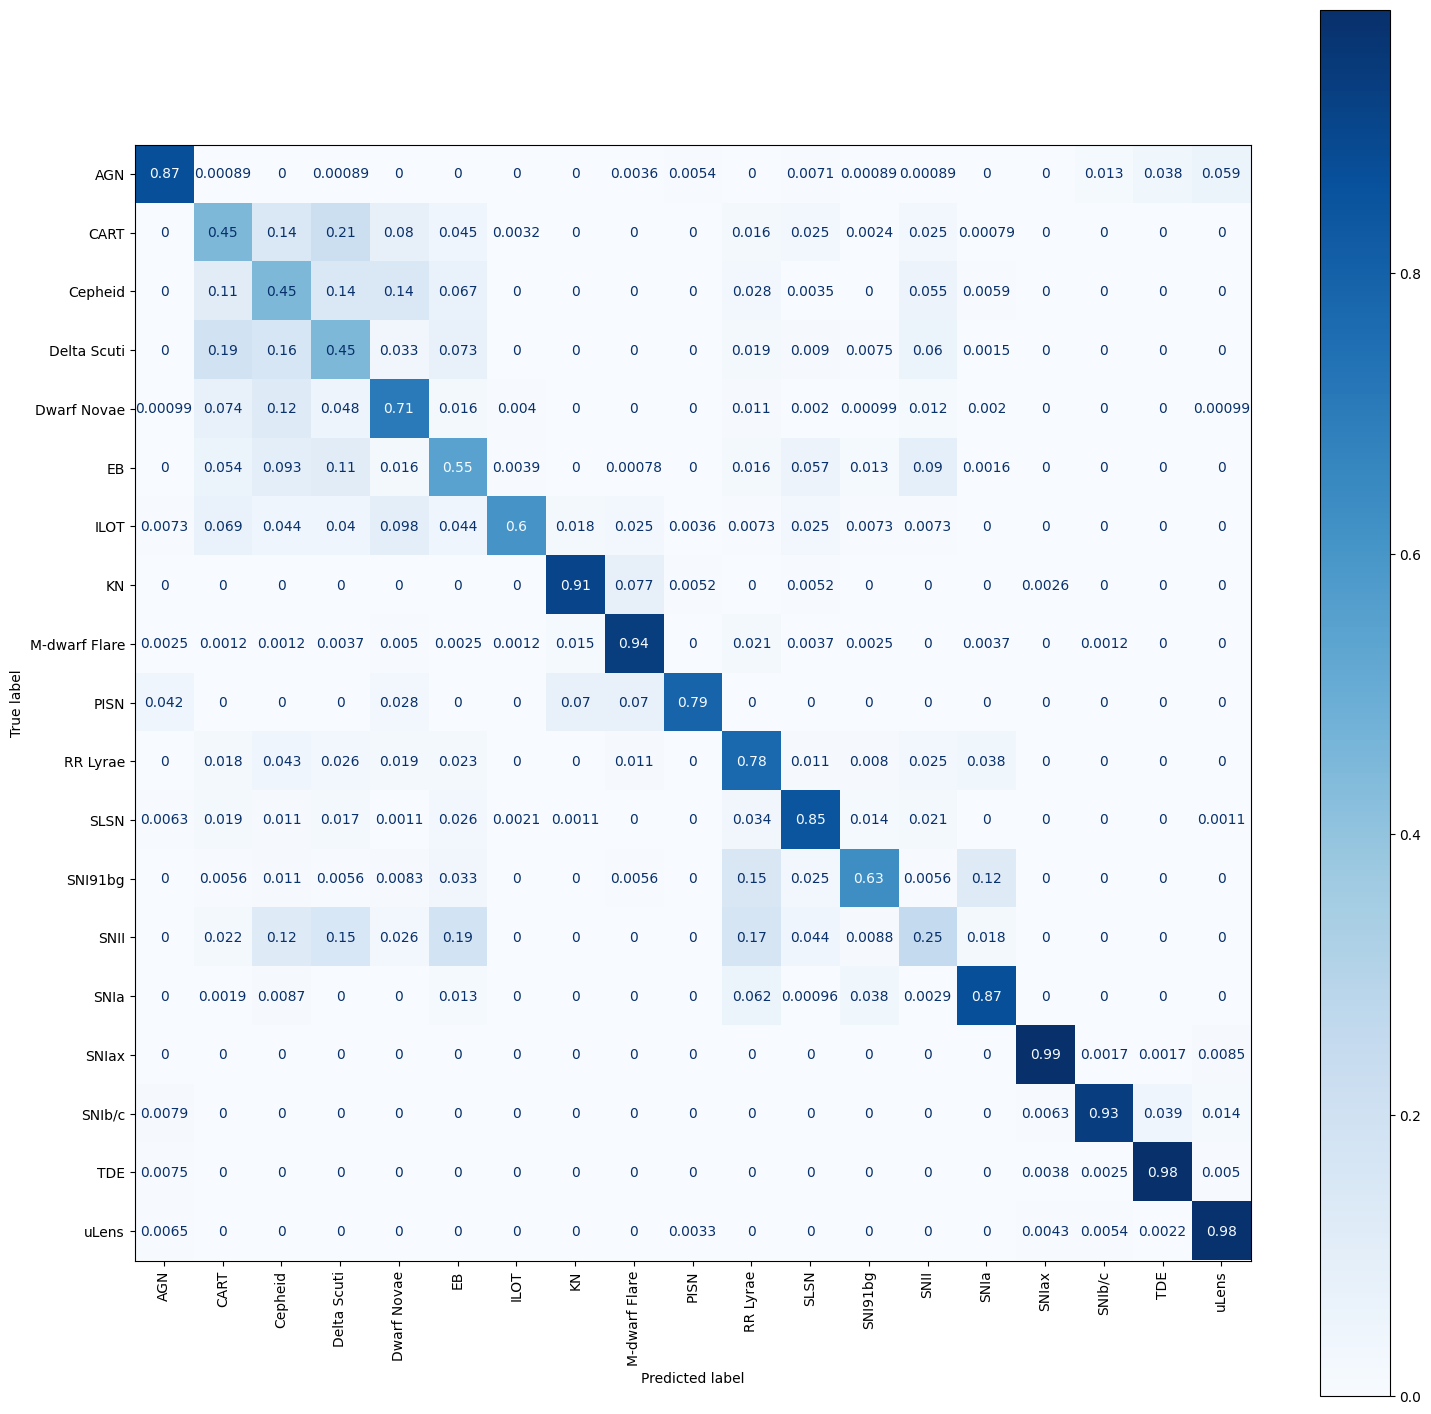

In [17]:
cm = confusion_matrix(Y_val_pred, Y_val_true, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=all_classes)
disp.plot(cmap=plt.cm.Blues)

fig = disp.figure_
plt.xticks(rotation=90)


fig.set_figwidth(18)
fig.set_figheight(18)
plt.savefig('baseline_leaf.png')

In [18]:
Y_val_pred = model1.predict([X_ts_val, X_static_val])
Y_val_pred = np.argmax(Y_val_pred[:, 1:3], axis=1)
Y_val_true = np.argmax(Y_val[:, 1:3], axis=1)

442/442 [==============================] - 4s 9ms/step


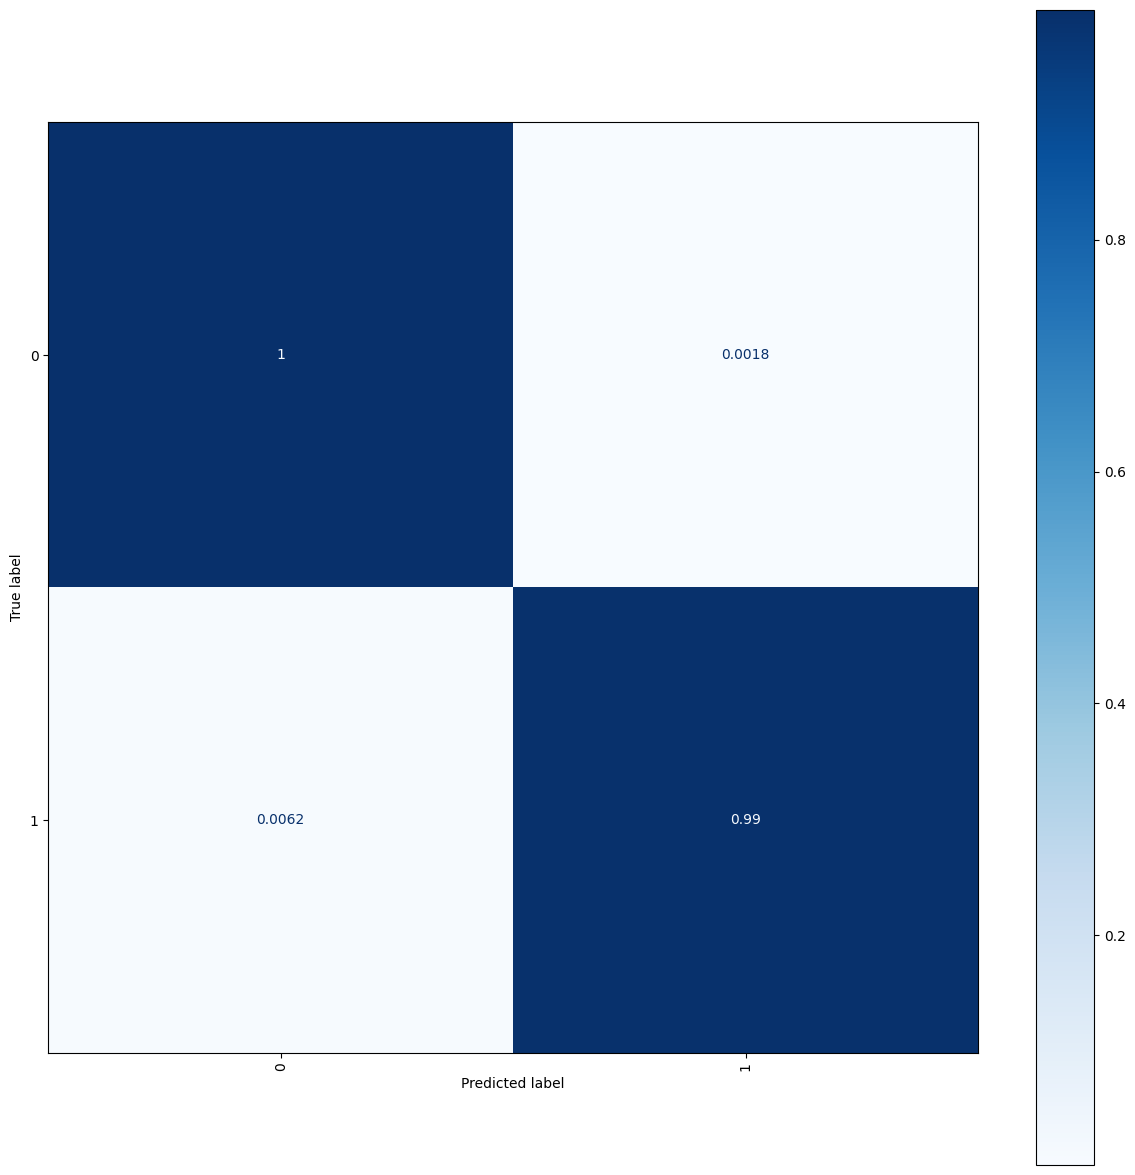

In [19]:
cm = confusion_matrix(Y_val_pred, Y_val_true, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

fig = disp.figure_
plt.xticks(rotation=90)


fig.set_figwidth(15)
fig.set_figheight(15)
plt.savefig('baseline_root.png')